# An Investigation of the Influence of Genetic Predisposition on the Development of Cardio Metabolic Conditions

### This document presents an investigation into the influence of genetic predisposition on the development of cardiometabolic conditions, specifically focusing on coronary heart disease (CHD). Using simulated patient data provided by my university, the project explores potential genetic risk factors for CHD, a leading cause of death in the U.S. and globally. While existing research highlights common risk factors like high body mass index (BMI), this study seeks to uncover whether genetic predispositions contribute to cardiometabolic conditions and CHD, offering new insights into preventive healthcare measures.

The proposed project utilized the Coherent Dataset, a synthetic collection of approximately 290,000 Electronic Health Records (EHRs) designed to replicate real-world healthcare data. This dataset, obtained from Synthea's repository, included comprehensive patient information such as demographics, clinical conditions, medications, and procedures, and was fully compliant with privacy regulations like HIPAA. The data, initially in CSV format, was loaded into Python using pandas, and merged by patient ID to create a unified dataset. Data cleaning and transformation were performed to address missing values and ensure data accuracy, while Python was used for efficient preprocessing. Rigorous quality assurance measures were implemented to validate data integrity at each stage. The cleaned dataset was securely stored with access restricted to the research team, ensuring compliance with institutional data policies and a thorough data management plan was developed to ensure transparency and reproducibility.

This retrospective study focused on a cohort of patients with recorded BMI values and at least one condition such as CHD, hyperlipidemia, hypertension, or prediabetes, excluding those who did not meet these criteria. Initial exploratory data analysis (EDA) revealed diverse demographics in age, gender, marital status, and race. The relationship between BMI and CHD was assessed using the highest recorded BMI value per patient to reduce bias, followed by calculating the correlation coefficient and visualizing the data with matplotlib and seaborn. We then explored the interaction between genetic predisposition and cardiometabolic conditions, focusing on genetic variations in the LDLR and PON1 genes. After identifying the top genes linked to pathogenic risks, chi-square tests and logistic regression were used to investigate associations between these variations and cardiometabolic conditions, with results visualized in forest plots and ROC curves to evaluate predictive performance. This analysis provided valuable insights into clinical risk factors like BMI and genetic predispositions contributing to cardiometabolic disorders.

The analysis of the Coherent Dataset revealed a diverse patient population, with the majority aged 91-100 years, a balanced gender distribution, and predominantly White racial composition. Initial exploration of the relationship between BMI and CHD showed no significant difference in BMI between patients with CHD and the general population, with an average BMI of 28.2 for CHD patients and 28.5 for the overall group. Further refinement by using the highest BMI per patient revealed a slight inverse relationship, though the Pearson correlation coefficient was -0.066, indicating a weak or negligible correlation. Genetic analysis focused on the PON1 and LDLR genes found significant associations with cardiometabolic conditions, with variations in these genes linked to lower odds of obesity, prediabetes, and hypertension, but higher odds of hyperlipidemia and more than twice the likelihood of CHD. Logistic regression models showed statistical significance, though with limited explanatory power, as indicated by low pseudo-R-squared values and AUC scores.

This study examined the relationship between BMI and CHD, finding a weak or nonexistent association after adjusting for potential biases, indicating that BMI alone may not be a reliable predictor of CHD risk in this sample population. Both groups, on average, remained in the overweight category, highlighting the complexity of using BMI as a sole risk factor. Genetic analysis revealed significant associations between variations in the LDLR and PON1 genes and cardiometabolic conditions, with these variations linked to lower odds of obesity, prediabetes, and hypertension but higher odds of hyperlipidemia and CHD. The strong association with CHD (odds ratio = 2.24) suggests that individuals with these genetic variations may benefit from early screening and preventive interventions. While logistic regression models confirmed the significance of these associations, the low pseudo-R-squared values indicate that genetic factors alone do not fully explain these conditions, pointing to other influences such as environmental or lifestyle factors. The modelâ€™s discriminatory power, particularly for CHD (AUC = 0.60), remained limited, underscoring the multifactorial nature of these diseases and the need for a comprehensive risk assessment approach.

In [7]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Secion 1: loading files
# Define folder paths
folder_path = r"coherent-11-07-2022/csv/"
dna_folder_path = r"coherent-11-07-2022/dna/"

# Function to load CSV files
def load_csv(file_name, folder_path):
    file_path = os.path.join(folder_path, file_name)
    return pd.read_csv(file_path)

# List of CSV files to load
csv_files = [
    'patients.csv', 'conditions.csv', 'observations.csv', 'medications.csv',
    'encounters.csv', 'procedures.csv', 'careplans.csv', 'payers.csv',
    'payer_transitions.csv'
]

# Dictionary to hold dataframes
data_frames = {}

# Load each CSV file into the dictionary
for file in csv_files:
    try:
        data_frames[file.split('.')[0]] = load_csv(file, folder_path)
        print(f"{file.split('.')[0]} dataframe shape: {data_frames[file.split('.')[0]].shape}")
    except FileNotFoundError as e:
        print(f"Error: {e}")

# Calculate the total number of unique patients using the 'Id' column
total_patients = data_frames['patients']['Id'].nunique()
print(f"Total number of unique patients: {total_patients}")

# Specific dataframes (if needed individually)
df_patients = data_frames['patients']
df_encounters = data_frames['encounters']
df_conditions = data_frames['conditions']
df_observations = data_frames['observations']

# Calculate the total number of unique patients using the 'Id' column
total_patients = data_frames['patients']['Id'].nunique()
print(f"Total number of unique patients: {total_patients}")

patients dataframe shape: (3539, 25)
conditions dataframe shape: (35874, 6)
observations dataframe shape: (1480409, 8)
medications dataframe shape: (371210, 13)
encounters dataframe shape: (285339, 15)
procedures dataframe shape: (134385, 8)
careplans dataframe shape: (14115, 9)
payers dataframe shape: (10, 21)
payer_transitions dataframe shape: (16328, 5)
Total number of unique patients: 3539
Total number of unique patients: 3539


In [9]:
# Function to convert birthdate to age
def convert_birthdate_to_age(df, birthdate_col='BIRTHDATE'):
    # Convert BIRTHDATE to datetime
    df[birthdate_col] = pd.to_datetime(df[birthdate_col], format='%Y-%m-%d', errors='coerce')
    
    # Check if the conversion was successful
    if not pd.api.types.is_datetime64_any_dtype(df[birthdate_col]):
        raise ValueError(f"{birthdate_col} column is not in datetime format.")
    
    today = pd.to_datetime('today')
    
    # Calculate age
    df['age'] = today.year - df[birthdate_col].dt.year
    df['age'] -= ((today.month < df[birthdate_col].dt.month) | 
                  ((today.month == df[birthdate_col].dt.month) & 
                   (today.day < df[birthdate_col].dt.day)))
    
    return df

# Function to calculate age group statistics
def calculate_age_group_stats(df, age_col='age'):
    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
    
    df['age_group'] = pd.cut(df[age_col], bins=bins, labels=labels, right=False)
    age_group_counts = df['age_group'].value_counts().sort_index()
    age_group_percentages = (age_group_counts / age_group_counts.sum()) * 100
    
    age_group_stats = pd.DataFrame({
        'Count': age_group_counts,
        'Percentage': age_group_percentages
    })
    
    return age_group_stats

# Main function to process patients data
def process_patients_data(data_frames):
    if 'patients' not in data_frames:
        raise FileNotFoundError("patients.csv not loaded.")
    
    patients_df = data_frames['patients']
    
    # Convert birthdate to age
    patients_df = convert_birthdate_to_age(patients_df)
    
    # Calculate age group statistics
    age_group_stats = calculate_age_group_stats(patients_df)
    
    print(age_group_stats)

# Assuming data_frames is already populated with the required data
try:
    process_patients_data(data_frames)
except Exception as e:
    print(f"Error: {e}")


           Count  Percentage
age_group                   
0-10           0    0.000000
11-20          0    0.000000
21-30        216    8.530806
31-40        204    8.056872
41-50        229    9.044234
51-60        252    9.952607
61-70        247    9.755134
71-80        297   11.729858
81-90        422   16.666667
91-100       665   26.263823


In [10]:
# Function to calculate counts and percentages
def calculate_counts_and_percentages(df, column):
    counts = df[column].value_counts()
    percentages = (counts / counts.sum()) * 100
    counts_and_percentages = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })
    return counts_and_percentages

# Main function to process patients data
def process_patients_data(data_frames):
    if 'patients' not in data_frames:
        raise FileNotFoundError("patients.csv not loaded.")
    
    patients_df = data_frames['patients']
    
    # Calculate and display counts and percentages for gender
    gender_stats = calculate_counts_and_percentages(patients_df, 'GENDER')
    print("Gender Distribution:")
    print(gender_stats)
    
    # Calculate and display counts and percentages for marital status
    marital_status_stats = calculate_counts_and_percentages(patients_df, 'MARITAL')
    print("\nMarital Status Distribution:")
    print(marital_status_stats)
    
    # Calculate and display counts and percentages for race
    race_stats = calculate_counts_and_percentages(patients_df, 'RACE')
    print("\nRace Distribution:")
    print(race_stats)

# Assuming data_frames is already populated with the required data
try:
    process_patients_data(data_frames)
except Exception as e:
    print(f"Error: {e}")


Gender Distribution:
        Count  Percentage
GENDER                   
M        1978   55.891495
F        1561   44.108505

Marital Status Distribution:
         Count  Percentage
MARITAL                   
M         2604   80.197105
S          643   19.802895

Race Distribution:
        Count  Percentage
RACE                     
white    2978   84.148064
black     316    8.929076
asian     233    6.583781
native      9    0.254309
other       3    0.084770


In [11]:
# Function to calculate mean and median
def calculate_statistics(df, column):
    mean_value = df[column].mean()
    median_value = df[column].median()
    return mean_value, median_value

# Function to count unique patients
def count_unique_patients(df, column):
    return df[column].nunique()

# Main function to process the data
def process_data(df_patients, df_conditions, df_observations):
    # Rename columns
    df_patients = df_patients.rename(columns={'Id': 'PATIENT'})

    # Merge Conditions and Observations dataframes
    merged_df = pd.merge(df_conditions, df_observations, on='PATIENT', how='inner')

    # Create a separate dataframe with all patients who have a BMI listed
    BMI_filtered_df = merged_df[(merged_df['DESCRIPTION_y'] == 'Body Mass Index')]
    
    # Convert 'VALUE' column to numeric
    BMI_filtered_df['VALUE'] = pd.to_numeric(BMI_filtered_df['VALUE'], errors='coerce')
    
    # Calculate and print the average and median BMI among all patients
    average_value_bmi, median_value_bmi = calculate_statistics(BMI_filtered_df, 'VALUE')
    print(f'The average BMI among all patients is: {average_value_bmi}')
    print(f'The median BMI among all patients is: {median_value_bmi}')

    # Filter the dataframe for patients with both BMI listed and Coronary Heart Disease
    chd_merged_df = merged_df[(merged_df['DESCRIPTION_y'] == 'Body Mass Index') & (merged_df['DESCRIPTION_x'] == 'Coronary Heart Disease')]
    
    # Convert 'VALUE' column to numeric
    chd_merged_df['VALUE'] = pd.to_numeric(chd_merged_df['VALUE'], errors='coerce')
    
    # Calculate and print the average and median BMI among patients with CHD
    average_value, median_value = calculate_statistics(chd_merged_df, 'VALUE')
    print(f'The average BMI among patients with CHD is: {average_value}')
    print(f'The median BMI among patients with CHD is: {median_value}')
    
    # Find and print the number of unique patients with a history of CHD
    unique_patients_chd = count_unique_patients(chd_merged_df, 'PATIENT')
    print(f'The number of unique patients with CHD are: {unique_patients_chd}')
    
    # Find and print the total number of unique patients
    unique_patients_all = count_unique_patients(BMI_filtered_df, 'PATIENT')
    print(f'The total number of unique patients is: {unique_patients_all}')

# Assuming data_frames is already populated with the required dataframes
df_patients = data_frames['patients']
df_conditions = data_frames['conditions']
df_observations = data_frames['observations']

# Process the data
process_data(df_patients, df_conditions, df_observations)


C:\Users\yashayi\AppData\Local\Temp\ipykernel_19636\1633786861.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMI_filtered_df['VALUE'] = pd.to_numeric(BMI_filtered_df['VALUE'], errors='coerce')


The average BMI among all patients is: 28.457413179654225
The median BMI among all patients is: 28.0


C:\Users\yashayi\AppData\Local\Temp\ipykernel_19636\1633786861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chd_merged_df['VALUE'] = pd.to_numeric(chd_merged_df['VALUE'], errors='coerce')


The average BMI among patients with CHD is: 28.23832742316785
The median BMI among patients with CHD is: 27.9
The number of unique patients with CHD are: 562
The total number of unique patients is: 3403


##### Analysis findings: There is not a significant difference in BMI between patients with CHD (N=562 unique patients with 10,152 total encounters) and all-comers (N=3403 unique patients with 598,650 total encounters). It's therefore possible that BMI does not have an association with a history of CHD, but we're worried this could be an incorrect assumption since there are duplicate rows for patients with frequent BMIs documented.  
##### Let's do this another way, by adding a column for CHD, where 1 indicated the patient has CHD and 0 indicates they do not, then selecting only one value per patient based on the highest recorded value. This will help to reduce patients with disproportionately more encounters weighing the data too heavily.

In [14]:
# Merge Conditions and Observations dataframes
merged_df = pd.merge(df_conditions, df_observations, on='PATIENT', how='inner')
    
# Create a separate dataframe with all patients who have a BMI listed
BMI_filtered_df = merged_df[(merged_df['DESCRIPTION_y'] == 'Body Mass Index')]

# Convert 'VALUE' column to numeric
BMI_filtered_df['VALUE'] = pd.to_numeric(BMI_filtered_df['VALUE'], errors='coerce')

# Create a 'CHD' column
BMI_filtered_df['CHD'] = BMI_filtered_df['DESCRIPTION_x'].apply(lambda x: 1 if x == 'Coronary Heart Disease' else 0)

# Reduce the dataframe to one row per unique patient, selecting only the highest BMI
BMI_filtered_df = BMI_filtered_df.loc[BMI_filtered_df.groupby('PATIENT')['VALUE'].idxmax()]

# Reset the index
BMI_filtered_df = BMI_filtered_df.reset_index(drop=True)

# Display the updated dataframe
BMI_filtered_df.head()
stats = BMI_filtered_df.groupby('CHD')['VALUE'].agg(['mean', 'median']).reset_index()

print(stats)

C:\Users\yashayi\AppData\Local\Temp\ipykernel_19636\916390930.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMI_filtered_df['VALUE'] = pd.to_numeric(BMI_filtered_df['VALUE'], errors='coerce')
C:\Users\yashayi\AppData\Local\Temp\ipykernel_19636\916390930.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BMI_filtered_df['CHD'] = BMI_filtered_df['DESCRIPTION_x'].apply(lambda x: 1 if x == 'Coronary Heart Disease' else 0)


   CHD       mean  median
0    0  28.648799   28.30
1    1  26.640625   27.65


In [15]:
correlation = BMI_filtered_df['VALUE'].corr(BMI_filtered_df['CHD']==1)
print(f'Correlation coefficient between BMI and heart attack: {correlation}')

Correlation coefficient between BMI and heart attack: -0.06603323055742473


#### Data Anaylis: You can see that by limiting the data set to one value per patient (their highest), we were able to show a meaningful difference between the two populations (those with CHD and those without). Here, it seems that those with CHD actually have a lower BMI on average. Let's see if we can depict this in a graph using MatPlotLib. 
#### Correlation coefficient value of -0.06603323055742473 is Very weak or no correlation

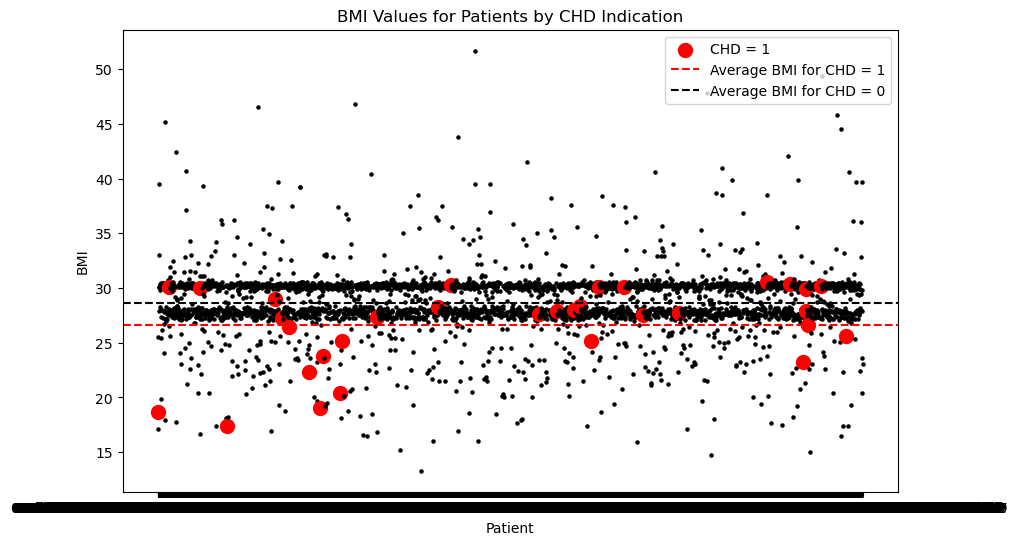

In [16]:
# Calculate average BMI for the two subgroups
average_BMI_CHD_1 = BMI_filtered_df[BMI_filtered_df['CHD'] == 1]['VALUE'].mean()
average_BMI_CHD_0 = BMI_filtered_df[BMI_filtered_df['CHD'] == 0]['VALUE'].mean()

# Plot the chart
plt.figure(figsize=(10, 6))

# Scatter plot
colors = {1: 'red', 0: 'black'}
sizes = {1: 100, 0: 5}

for i, row in BMI_filtered_df.iterrows():
    plt.scatter(row['PATIENT'], row['VALUE'], color=colors[row['CHD']], s=sizes[row['CHD']], 
                label=f"CHD = {row['CHD']}" if row['CHD'] == 1 and i == 0 else "")

# Add lines for average BMI
plt.axhline(y=average_BMI_CHD_1, color='red', linestyle='--', label='Average BMI for CHD = 1')
plt.axhline(y=average_BMI_CHD_0, color='black', linestyle='--', label='Average BMI for CHD = 0')

# Labels and title
plt.xlabel('Patient')
plt.ylabel('BMI')
plt.title('BMI Values for Patients by CHD Indication')

# Legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

#### Data Analysis: Based on the plot above, one can see that the patients with CHD on average have a lower BMI than those without CHD. Interestingly, the average BMI in both populations is considered overweight but not obese by CDC convention.

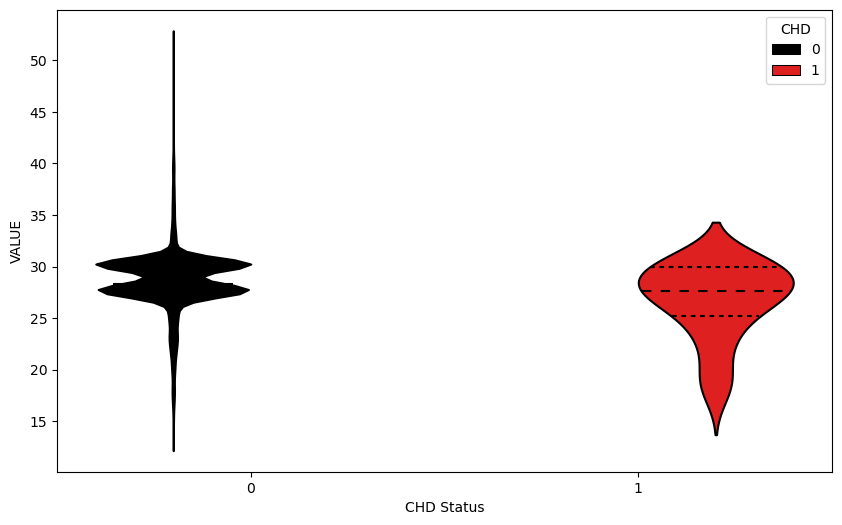

In [17]:
# A violin plot is an even better way to depict this
# Plot CHD vs VALUE
plt.figure(figsize=(10, 6))
sns.violinplot(x='CHD', y='VALUE', hue='CHD', data=BMI_filtered_df, palette={0: 'black', 1: 'red'}, inner='quartile', legend=False)
plt.xlabel('CHD Status')
# Show plot
plt.show()

#### Genetic Predisposition:

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score, auc

Missing Values:
 INDEX                          0
INDEX_PREFIX                   0
CHROMOSOME                     0
LOCATION                       0
STRAND                         0
ANCESTRAL_ALLELE               0
VARIANT_ALLELE_LIST            0
GENE                           0
CLINICAL_SIGNIFICANCE          0
ALLELE                         0
VARIANT                        0
PATIENT_ID                     0
Id                             0
BIRTHDATE                      0
DEATHDATE                1663774
SSN                            0
DRIVERS                    13202
PASSPORT                   18032
PREFIX                     16422
FIRST                          0
LAST                           0
SUFFIX                   3548762
MAIDEN                   2579542
MARITAL                    37030
RACE                           0
ETHNICITY                      0
GENDER                         0
BIRTHPLACE                     0
ADDRESS                        0
CITY                      

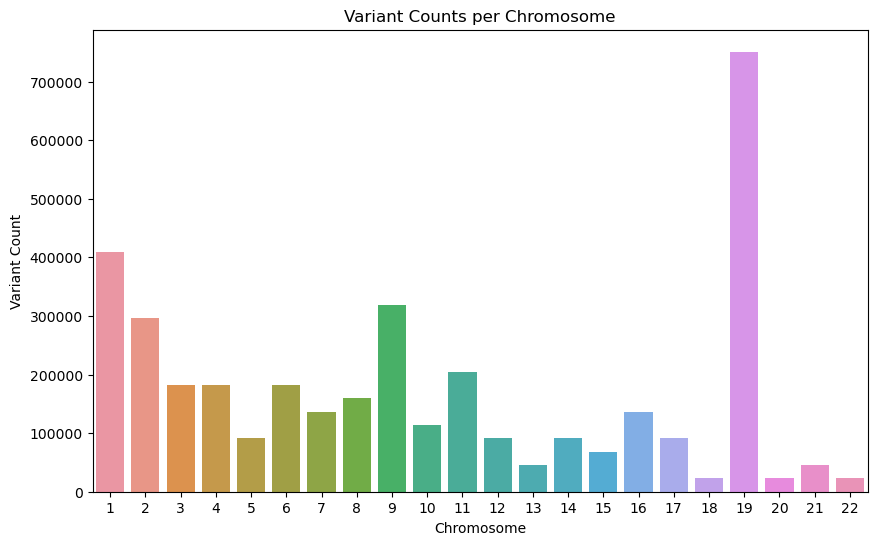


Clinical Significance Counts:
CLINICAL_SIGNIFICANCE
Uncertain            1797724
Pathogenic            819216
Benign                273072
Risk Factor           250316
Likely Pathogenic     159292
Association           136536
Drug Response         136536
Likely Benign          91024
Name: count, dtype: int64


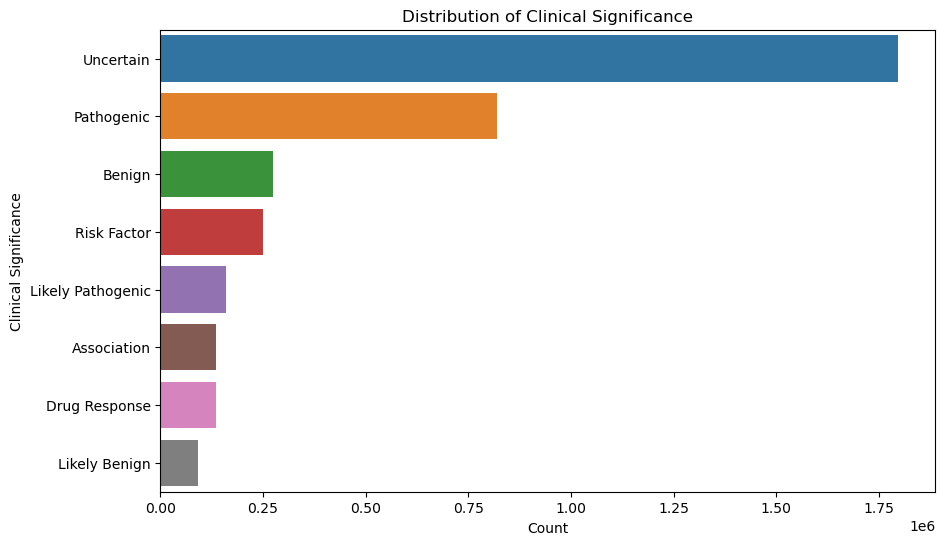


Top Genes for Pathogenic Variants:
GENE
LDLR      227560
BMPR2      68268
MYBPC3     45512
Name: count, dtype: int64


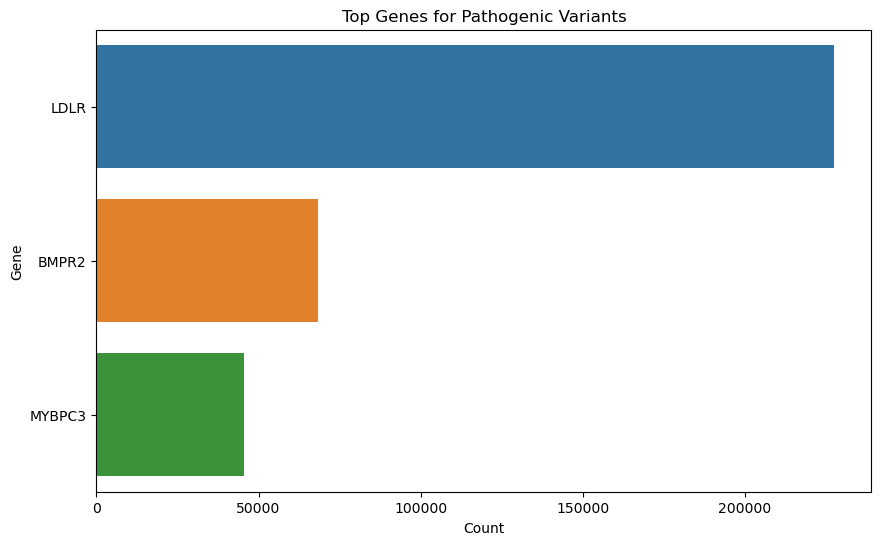


Top Genes for Risk Factor Variants:
GENE
PON1    45512
LRP8    22756
AGT     22756
Name: count, dtype: int64


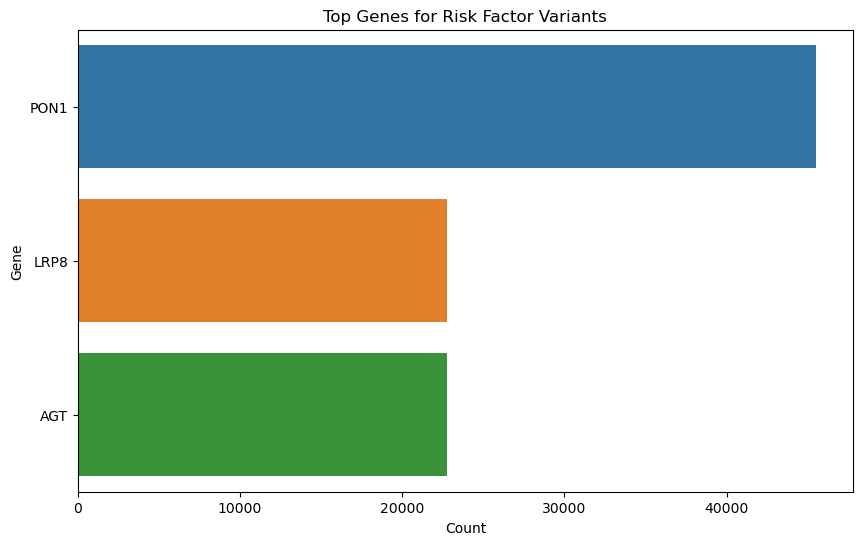

In [19]:
# Load the patients and conditions data
patients_df = pd.read_csv(os.path.join(folder_path, "patients.csv"))
conditions_df = pd.read_csv(os.path.join(folder_path, "conditions.csv"))

# Adjust column names
patient_id_column = 'Id'  # column name in patients_df
condition_patient_id_column = 'PATIENT'  # column name in conditions_df

# Store merged dataframes
dataframes = []

# Extract patient ID from file name
def extract_patient_id(file_name):
    return file_name.split('_')[-2]

# Analyze dataframe for missing values
def analyze_dataframe(df):
    missing_values = df.isnull().sum()
    return missing_values

# Loop through each file in the DNA folder
for file_name in os.listdir(dna_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(dna_folder_path, file_name)
        # Read the DNA CSV file into a dataframe
        dna_df = pd.read_csv(file_path)
        # Extract patient ID and add it to the dataframe
        patient_id = extract_patient_id(file_name)
        dna_df['PATIENT_ID'] = patient_id
        # Merge with patient data
        merged_df = dna_df.merge(patients_df, left_on='PATIENT_ID', right_on=patient_id_column, how='left')
        # Merge with condition data
        merged_df = merged_df.merge(conditions_df, left_on='PATIENT_ID', right_on=condition_patient_id_column, how='left')
        # Store the merged dataframe in the list
        dataframes.append(merged_df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Analyze the combined dataframe
missing_values = analyze_dataframe(combined_df)
print("Missing Values:\n", missing_values)

# Group by chromosome and count the number of variants
chromosome_counts = combined_df['CHROMOSOME'].value_counts()

# Find the chromosome with the highest variant count
highest_variant_chromosome = chromosome_counts.idxmax()
highest_variant_count = chromosome_counts.max()

print(f"\nThe chromosome with the highest variant count is: {highest_variant_chromosome}")
print(f"Number of variants in this chromosome: {highest_variant_count}")

# Plotting the variant counts per chromosome
plt.figure(figsize=(10, 6))
sns.barplot(x=chromosome_counts.index, y=chromosome_counts.values)
plt.title('Variant Counts per Chromosome')
plt.xlabel('Chromosome')
plt.ylabel('Variant Count')
plt.show()

# Analyzing clinical significance
clinical_significance_counts = combined_df['CLINICAL_SIGNIFICANCE'].value_counts()
print(f"\nClinical Significance Counts:\n{clinical_significance_counts}")

# Visualizing clinical significance
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, y='CLINICAL_SIGNIFICANCE', order=clinical_significance_counts.index)
plt.title('Distribution of Clinical Significance')
plt.xlabel('Count')
plt.ylabel('Clinical Significance')
plt.show()

# Focus on "Pathogenic" and "Risk Factor" variants
pathogenic_df = combined_df[combined_df['CLINICAL_SIGNIFICANCE'] == 'Pathogenic']
risk_factor_df = combined_df[combined_df['CLINICAL_SIGNIFICANCE'] == 'Risk Factor']

# Analyzing genes associated with these variants
pathogenic_genes = pathogenic_df['GENE'].value_counts()
risk_factor_genes = risk_factor_df['GENE'].value_counts()

# The top 3 pathogenic genes
print("\nTop Genes for Pathogenic Variants:")
print(pathogenic_genes.head(3))

# Visualize the top 3 genes for Pathogenic Variants
plt.figure(figsize=(10, 6))
sns.barplot(x=pathogenic_genes.head(3).values, y=pathogenic_genes.head(3).index)
plt.title('Top Genes for Pathogenic Variants')
plt.xlabel('Count')
plt.ylabel('Gene')
plt.show()

# The top 3 genes for Risk Factor Variants
print("\nTop Genes for Risk Factor Variants:")
print(risk_factor_genes.head(3))

# Visualize the top 3 genes for Risk Factor Variants
plt.figure(figsize=(10, 6))
sns.barplot(x=risk_factor_genes.head(3).values, y=risk_factor_genes.head(3).index)
plt.title('Top Genes for Risk Factor Variants')
plt.xlabel('Count')
plt.ylabel('Gene')
plt.show()


In [20]:
# Filter for variations in Chromosome 19
chromosome_19_df = combined_df[combined_df['CHROMOSOME'] == 19]

# Get unique patient IDs with variations in Chromosome 19
patients_with_chr19_variations = chromosome_19_df['PATIENT_ID'].unique()

# Filter the patients dataframe to include only these patients
patients_df = pd.read_csv(os.path.join(folder_path, "patients.csv"))
patients_with_variations_df = patients_df[patients_df['Id'].isin(patients_with_chr19_variations)]

# Analyze gender distribution
gender_distribution = patients_with_variations_df['GENDER'].value_counts()
gender_percentages = (gender_distribution / gender_distribution.sum()) * 100
gender_distribution_df = pd.DataFrame({
    'Count': gender_distribution,
    'Percentage': gender_percentages
})
print("Gender Distribution of Patients with Chromosome 19 Variations:")
print(gender_distribution_df)

# Analyze race distribution
race_distribution = patients_with_variations_df['RACE'].value_counts()
race_percentages = (race_distribution / race_distribution.sum()) * 100
race_distribution_df = pd.DataFrame({
    'Count': race_distribution,
    'Percentage': race_percentages
})
print("\nRace Distribution of Patients with Chromosome 19 Variations:")
print(race_distribution_df)

# Analyze conditions of these patients
conditions_df = pd.read_csv(os.path.join(folder_path, "conditions.csv"))
conditions_of_patients_with_variations = conditions_df[conditions_df['PATIENT'].isin(patients_with_chr19_variations)]

# Count the conditions
conditions_count = conditions_of_patients_with_variations['DESCRIPTION'].value_counts()
print("\nConditions of Patients with Chromosome 19 Variations:")
print(conditions_count.head(10))  # Display the top 10 conditions

Gender Distribution of Patients with Chromosome 19 Variations:
        Count  Percentage
GENDER                   
M         552   62.092238
F         337   37.907762

Race Distribution of Patients with Chromosome 19 Variations:
        Count  Percentage
RACE                     
white     729   82.002250
black      98   11.023622
asian      59    6.636670
native      3    0.337458

Conditions of Patients with Chromosome 19 Variations:
DESCRIPTION
Viral sinusitis (disorder)                 988
Stroke                                     691
Acute viral pharyngitis (disorder)         564
Body mass index 30+ - obesity (finding)    499
Anemia (disorder)                          415
Prediabetes                                411
Acute bronchitis (disorder)                392
Chronic sinusitis (disorder)               344
Hyperlipidemia                             300
Coronary Heart Disease                     286
Name: count, dtype: int64


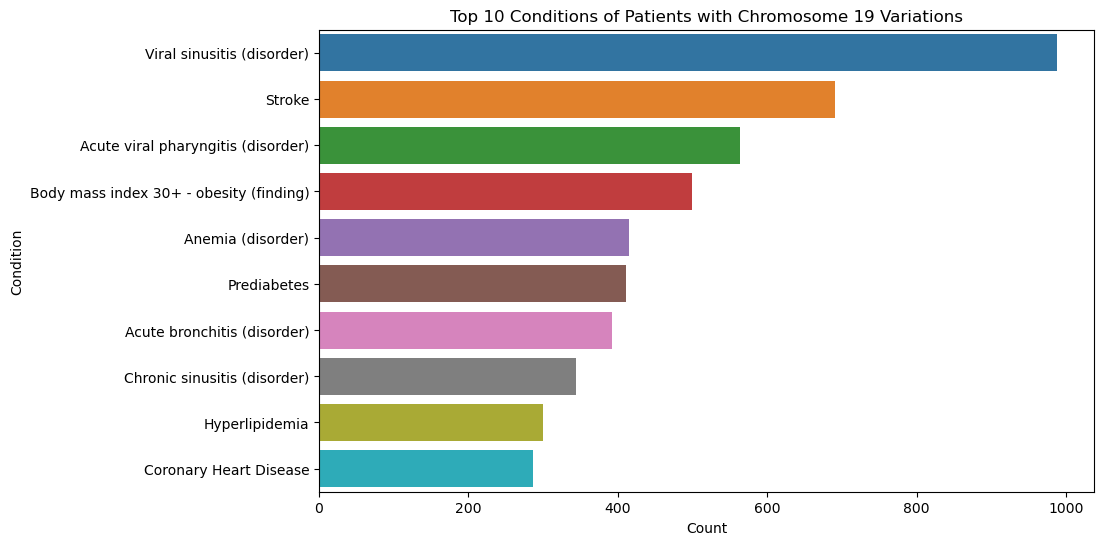

In [21]:
# Plotting the top 10 conditions
plt.figure(figsize=(10, 6))
sns.barplot(x=conditions_count.head(10).values, y=conditions_count.head(10).index)
plt.title('Top 10 Conditions of Patients with Chromosome 19 Variations')
plt.xlabel('Count')
plt.ylabel('Condition')
plt.show()

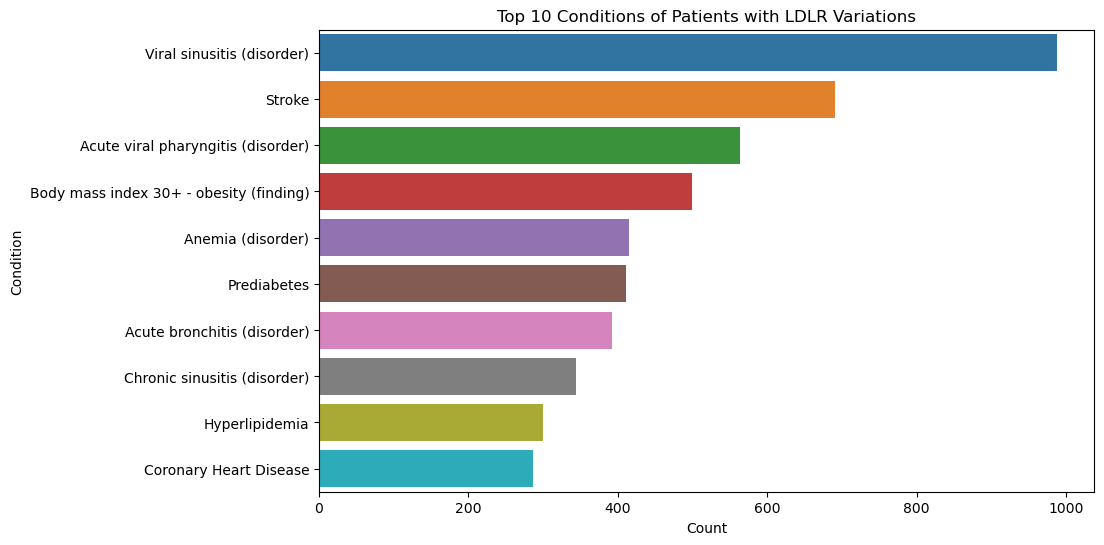

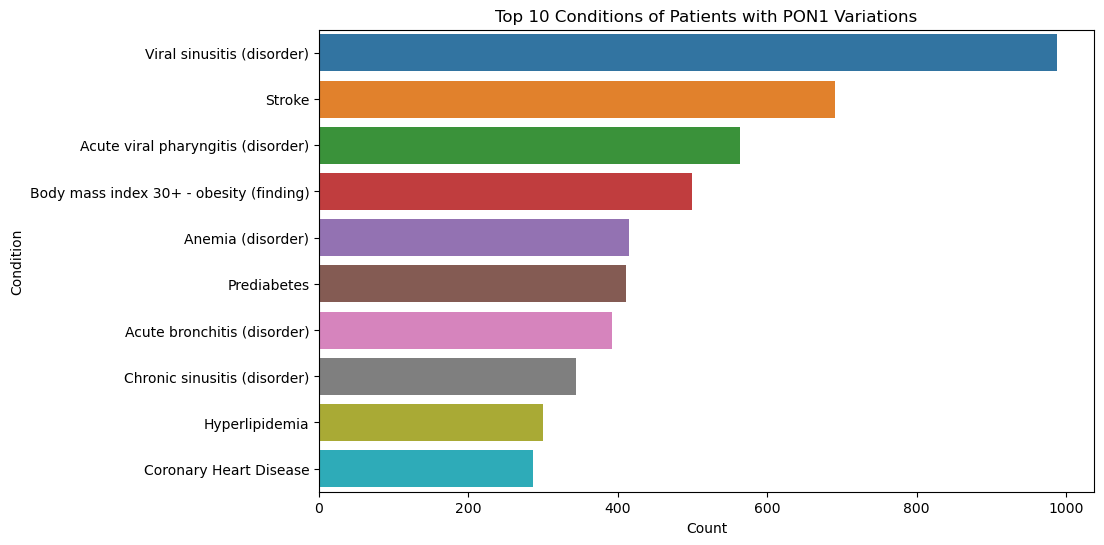

In [22]:
# Function to analyze gene data
def analyze_gene(gene_name):
    # Filter for variations in the specified gene
    gene_df = combined_df[combined_df['GENE'] == gene_name]

    # Get unique patient IDs with variations in this gene
    patients_with_gene_variations = gene_df['PATIENT_ID'].unique()

    # Filter the patients dataframe to include only these patients
    patients_with_variations_df = patients_df[patients_df['Id'].isin(patients_with_gene_variations)]

    # Analyze conditions of these patients
    conditions_of_patients_with_variations = conditions_df[conditions_df['PATIENT'].isin(patients_with_gene_variations)]

    # Plotting the top 10 conditions
    plt.figure(figsize=(10, 6))
    sns.barplot(x=conditions_count.head(10).values, y=conditions_count.head(10).index)
    plt.title(f'Top 10 Conditions of Patients with {gene_name} Variations')
    plt.xlabel('Count')
    plt.ylabel('Condition')
    plt.show()

# Analyze genes LDLR and PON1
genes_to_analyze = ['LDLR', 'PON1']
for gene in genes_to_analyze:
    analyze_gene(gene)


In [23]:
from scipy.stats import chi2_contingency
# store unique patient IDs for each gene
ldlr_patients, pon1_patients = [], []

# Loop through each file in the DNA folder
for file_name in filter(lambda f: f.endswith('.csv'), os.listdir(dna_folder_path)):
    file_path = os.path.join(dna_folder_path, file_name)
    dna_df = pd.read_csv(file_path)
    patient_id = extract_patient_id(file_name)
    if not dna_df[dna_df['GENE'] == 'LDLR'].empty:
        ldlr_patients.append(patient_id)
    if not dna_df[dna_df['GENE'] == 'PON1'].empty:
        pon1_patients.append(patient_id)

# Combine unique patient IDs with variations in LDLR or PON1
unique_patients_with_variations = set(ldlr_patients + pon1_patients)

# Add a column indicating whether the patient has any genetic variation of interest
patients_df['HAS_VARIATION'] = patients_df['Id'].isin(unique_patients_with_variations).astype(int)

# Merge patient data with conditions data
merged_df = pd.merge(patients_df, conditions_df, left_on='Id', right_on='PATIENT')

# Function to perform chi-square test and display contingency table
def chi_square_test(df, condition, variation_column):
    contingency_table = pd.crosstab(df[condition], df[variation_column])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# the conditions of interest and variation column
conditions_of_interest = [
    'Body mass index 30+ - obesity (finding)', 
    'Prediabetes', 
    'Hypertension', 
    'Hyperlipidemia', 
    'Coronary Heart Disease'
]
variation_column = 'HAS_VARIATION'

# Performing chi-square tests
chi_square_results = {
    condition: chi_square_test(merged_df.assign(**{condition: merged_df['DESCRIPTION'] == condition}), condition, variation_column)
    for condition in conditions_of_interest
}

# Print the results
for condition, p_value in chi_square_results.items():
    print(f"Chi-Square Test for {condition}: p-value = {p_value}")

Chi-Square Test for Body mass index 30+ - obesity (finding): p-value = 2.97978843381244e-06
Chi-Square Test for Prediabetes: p-value = 9.254805208368595e-05
Chi-Square Test for Hypertension: p-value = 4.395322879368691e-07
Chi-Square Test for Hyperlipidemia: p-value = 0.006723173350316609
Chi-Square Test for Coronary Heart Disease: p-value = 3.445412715921421e-22


In [24]:
# the conditions of interest
conditions_of_interest = [
    'Body mass index 30+ - obesity (finding)', 
    'Prediabetes', 
    'Hypertension', 
    'Hyperlipidemia', 
    'Coronary Heart Disease'
]

# Performing logistic regression for each condition
logistic_regression_results = {}
for condition in conditions_of_interest:
    merged_df[condition] = merged_df['DESCRIPTION'] == condition
    X = merged_df[['HAS_VARIATION']]
    y = merged_df[condition]
    X = sm.add_constant(X)
    model = sm.Logit(y, X)
    result = model.fit()
    logistic_regression_results[condition] = result.summary()
    print(f"Logistic Regression for {condition}:\n{result.summary()}\n")


Optimization terminated successfully.
         Current function value: 0.203848
         Iterations 7
Logistic Regression for Body mass index 30+ - obesity (finding):
                                      Logit Regression Results                                     
Dep. Variable:     Body mass index 30+ - obesity (finding)   No. Observations:                35874
Model:                                               Logit   Df Residuals:                    35872
Method:                                                MLE   Df Model:                            1
Date:                                     Tue, 30 Jul 2024   Pseudo R-squ.:                0.001551
Time:                                             21:53:16   Log-Likelihood:                -7312.8
converged:                                            True   LL-Null:                       -7324.2
Covariance Type:                                 nonrobust   LLR p-value:                 1.877e-06
                    coef    std e

##### Patients with genetic variations in the genes LDLR and PON1 are less likely to have Body Mass Index 30+, Prediabetes, and Hypertension, as indicated by the negative coefficients in the logistic regression models. These associations are statistically significant, which means the results are reliable and not due to random chance. On the other hand, patients with genetic variations in the genes LDLR and PON1 more likely to have Hyperlipidemia and Coronary Heart Disease, as shown by the positive coefficients, which are also statistically significant. However, the low Pseudo R-squared values indicate that these genetic variations alone do not explain much of the variability in these conditions, suggesting that other factors are likely involved.

Odds Ratio for Body mass index 30+ - obesity (finding):
Odds Ratio = 0.7778760176928889, p-value = 2.97978843381244e-06, 95% CI = [0.7003114876554725, 0.8640313768484562]

Odds Ratio for Prediabetes:
Odds Ratio = 0.7933055439456997, p-value = 9.254805208368595e-05, 95% CI = [0.7067804879151665, 0.8904231183735241]

Odds Ratio for Hypertension:
Odds Ratio = 0.7018587568596169, p-value = 4.395322879368691e-07, 95% CI = [0.6119026524964234, 0.8050393515550356]

Odds Ratio for Hyperlipidemia:
Odds Ratio = 1.222201482451604, p-value = 0.006723173350316609, 95% CI = [1.058988167874935, 1.4105695502759454]

Odds Ratio for Coronary Heart Disease:
Odds Ratio = 2.238063016775951, p-value = 3.445412715921421e-22, 95% CI = [1.894891694990264, 2.643383830486418]



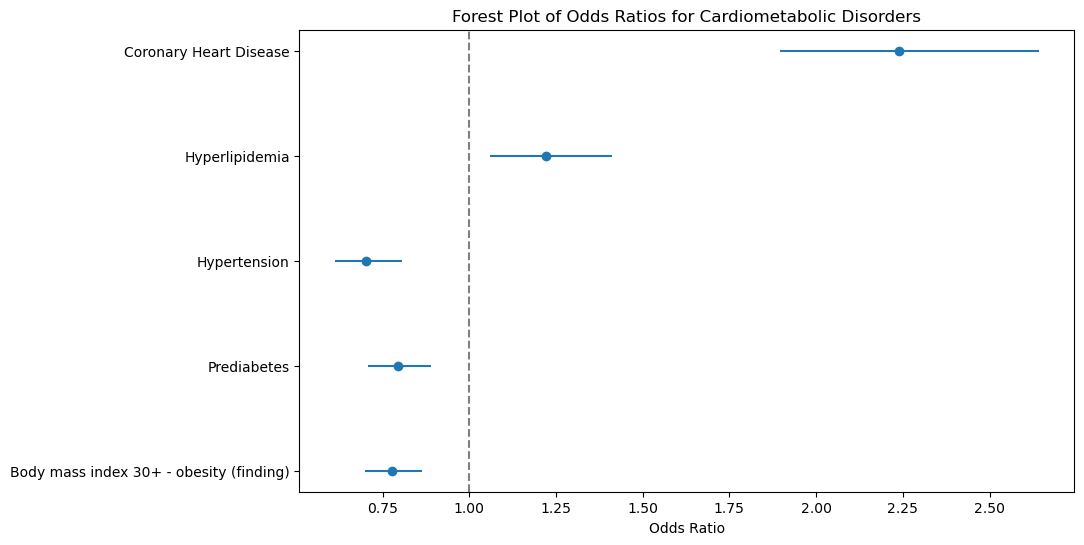

In [25]:
# calculate odds ratio and confidence interval
def calculate_odds_ratio(df, condition, variation_column):
    contingency_table = pd.crosstab(df[condition], df[variation_column])
    odds_ratio, p_value = sm.stats.Table2x2(contingency_table.values).oddsratio, chi_square_test(df, condition, variation_column)
    ci_lower, ci_upper = sm.stats.Table2x2(contingency_table.values).oddsratio_confint()
    return odds_ratio, p_value, ci_lower, ci_upper

# Calculate odds ratios for each condition
odds_ratios = {}
for condition in conditions_of_interest:
    merged_df[condition] = merged_df['DESCRIPTION'] == condition
    odds_ratio, p_value, ci_lower, ci_upper = calculate_odds_ratio(merged_df, condition, 'HAS_VARIATION')
    odds_ratios[condition] = {
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }
    print(f"Odds Ratio for {condition}:\nOdds Ratio = {odds_ratio}, p-value = {p_value}, 95% CI = [{ci_lower}, {ci_upper}]\n")
    

# setting up dataframe for forest plot
forest_plot_data = []
for condition, stats in odds_ratios.items():
    forest_plot_data.append({
        'Condition': condition,
        'Odds Ratio': stats['odds_ratio'],
        'CI Lower': stats['ci_lower'],
        'CI Upper': stats['ci_upper']
    })
forest_plot_df = pd.DataFrame(forest_plot_data)

# Forest plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(forest_plot_df['Odds Ratio'], forest_plot_df['Condition'], xerr=[forest_plot_df['Odds Ratio'] - forest_plot_df['CI Lower'], forest_plot_df['CI Upper'] - forest_plot_df['Odds Ratio']], fmt='o')
ax.axvline(x=1, color='grey', linestyle='--')
plt.title('Forest Plot of Odds Ratios for Cardiometabolic Disorders')
plt.xlabel('Odds Ratio')
plt.show()


##### Body Mass Index 30+: Patients with genetic variations are about 22% less likely to have obesity (odds ratio = 0.778). Prediabetes: Patients with genetic variations are about 21% less likely to have prediabetes (odds ratio = 0.793). Hypertension: Patients with genetic variations are about 30% less likely to have hypertension (odds ratio = 0.702). Hyperlipidemia: Patients with genetic variations are about 22% more likely to have hyperlipidemia (odds ratio = 1.222). Coronary Heart Disease: Patients with genetic variations are more than twice as likely to have coronary heart disease (odds ratio = 2.238).

Optimization terminated successfully.
         Current function value: 0.203848
         Iterations 7
Logistic Regression for Body mass index 30+ - obesity (finding):
                                      Logit Regression Results                                     
Dep. Variable:     Body mass index 30+ - obesity (finding)   No. Observations:                35874
Model:                                               Logit   Df Residuals:                    35872
Method:                                                MLE   Df Model:                            1
Date:                                     Tue, 30 Jul 2024   Pseudo R-squ.:                0.001551
Time:                                             21:53:17   Log-Likelihood:                -7312.8
converged:                                            True   LL-Null:                       -7324.2
Covariance Type:                                 nonrobust   LLR p-value:                 1.877e-06
                    coef    std e

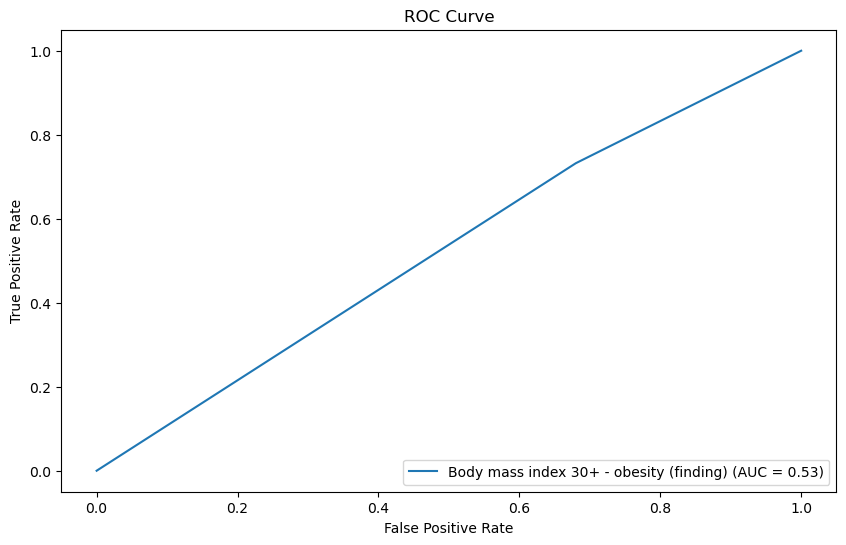

Optimization terminated successfully.
         Current function value: 0.174836
         Iterations 7
Logistic Regression for Prediabetes:
                           Logit Regression Results                           
Dep. Variable:            Prediabetes   No. Observations:                35874
Model:                          Logit   Df Residuals:                    35872
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jul 2024   Pseudo R-squ.:                0.001268
Time:                        21:53:17   Log-Likelihood:                -6272.1
converged:                       True   LL-Null:                       -6280.0
Covariance Type:            nonrobust   LLR p-value:                 6.570e-05
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.0525      0.031    -99.155      0.000      -3

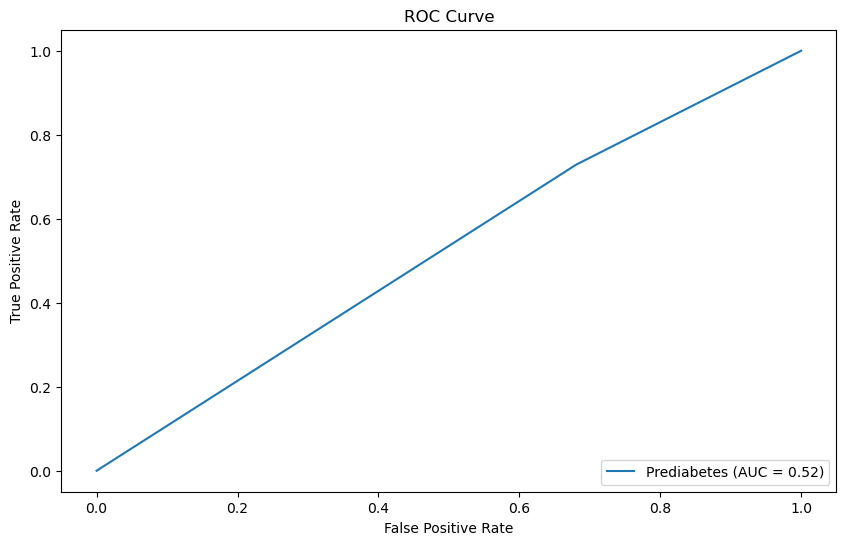

Optimization terminated successfully.
         Current function value: 0.139157
         Iterations 8
Logistic Regression for Hypertension:
                           Logit Regression Results                           
Dep. Variable:           Hypertension   No. Observations:                35874
Model:                          Logit   Df Residuals:                    35872
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jul 2024   Pseudo R-squ.:                0.002696
Time:                        21:53:17   Log-Likelihood:                -4992.1
converged:                       True   LL-Null:                       -5005.6
Covariance Type:            nonrobust   LLR p-value:                 2.046e-07
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.3294      0.035    -95.206      0.000      -

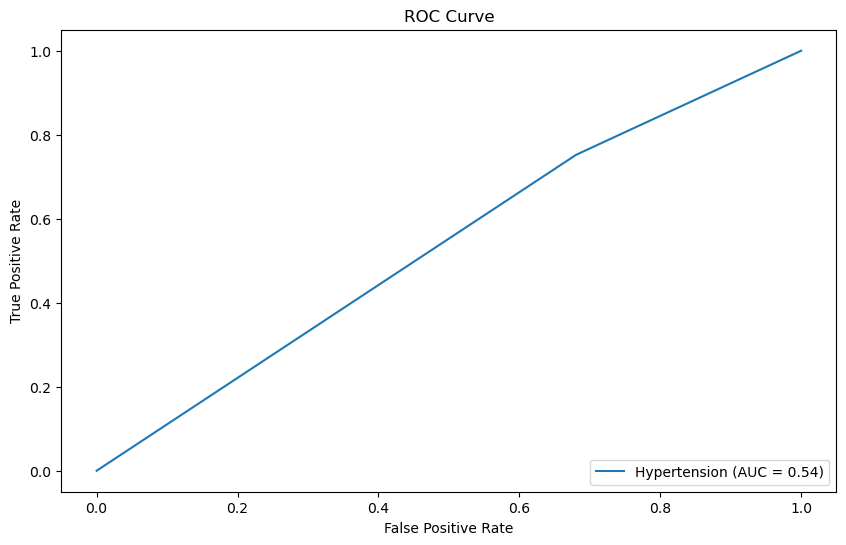

Optimization terminated successfully.
         Current function value: 0.110008
         Iterations 8
Logistic Regression for Hyperlipidemia:
                           Logit Regression Results                           
Dep. Variable:         Hyperlipidemia   No. Observations:                35874
Model:                          Logit   Df Residuals:                    35872
Method:                           MLE   Df Model:                            1
Date:                Tue, 30 Jul 2024   Pseudo R-squ.:               0.0009349
Time:                        21:53:18   Log-Likelihood:                -3946.4
converged:                       True   LL-Null:                       -3950.1
Covariance Type:            nonrobust   LLR p-value:                  0.006574
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.8096      0.044    -86.829      0.000     

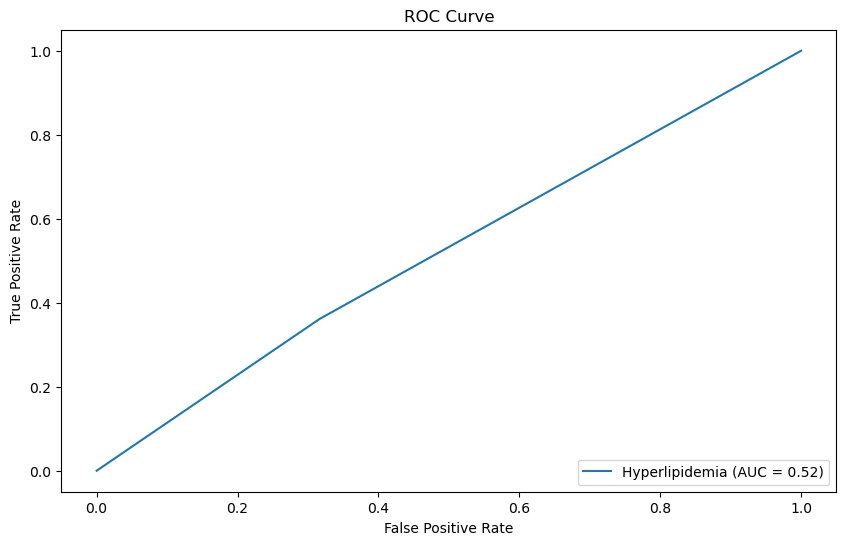

Optimization terminated successfully.
         Current function value: 0.079773
         Iterations 8
Logistic Regression for Coronary Heart Disease:
                             Logit Regression Results                             
Dep. Variable:     Coronary Heart Disease   No. Observations:                35874
Model:                              Logit   Df Residuals:                    35872
Method:                               MLE   Df Model:                            1
Date:                    Tue, 30 Jul 2024   Pseudo R-squ.:                 0.01515
Time:                            21:53:18   Log-Likelihood:                -2861.8
converged:                           True   LL-Null:                       -2905.8
Covariance Type:                nonrobust   LLR p-value:                 6.386e-21
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.46

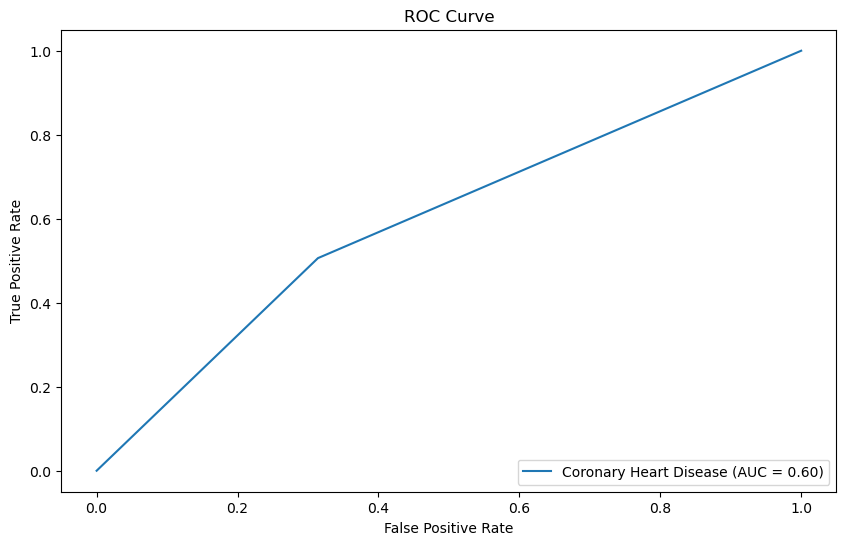


AUC Results:
Body mass index 30+ - obesity (finding): AUC = 0.53
Prediabetes: AUC = 0.52
Hypertension: AUC = 0.54
Hyperlipidemia: AUC = 0.52
Coronary Heart Disease: AUC = 0.60


In [26]:
# Initialize lists for ROC and AUC results
roc_auc_results = {}

# Logistic regression for each condition
for condition in conditions_of_interest:
    merged_df[condition] = merged_df['DESCRIPTION'] == condition
    X = merged_df[['HAS_VARIATION']]
    y = merged_df[condition]
    X = sm.add_constant(X)
    model = sm.Logit(y, X)
    result = model.fit()
    
    # Predict probabilities
    y_pred_prob = result.predict(X)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    roc_auc_results[condition] = roc_auc
    
    # Print logistic regression results
    print(f"Logistic Regression for {condition}:\n{result.summary()}\n")
    
    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{condition} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Print AUC results
print("\nAUC Results:")
for condition, auc_score in roc_auc_results.items():
    print(f"{condition}: AUC = {auc_score:.2f}")

#### Data Analysis: HAS_VARIATION is a significant predictor, negatively associated with obesity, though the model's discrimination ability is weak (AUC = 0.53).
#### HAS_VARIATION is a significant predictor, negatively associated with prediabetes, but the model's discrimination ability is weak (AUC = 0.52).
#### HAS_VARIATION is a significant predictor, negatively associated with hypertension, though the model's discrimination ability is weak (AUC = 0.54).
#### HAS_VARIATION is a significant predictor, positively associated with hyperlipidemia, but the model's discrimination ability is weak (AUC = 0.52).
#### HAS_VARIATION is a significant predictor, positively associated with coronary heart disease, and the model's discrimination ability is modest (AUC = 0.60).
 
#### HAS_VARIATION as a Predictor: It is statistically significant across all conditions, indicating it has an association with each health outcome.
#### Negative Association: For obesity, prediabetes, and hypertension, indicating that HAS_VARIATION is associated with lower odds of these conditions.
#### Positive Association: For hyperlipidemia and coronary heart disease, indicating that HAS_VARIATION is associated with higher odds of these conditions.
 
#### All models have relatively low AUC values, indicating weak discriminatory power. The highest AUC is for coronary heart disease (0.60), suggesting modest predictive ability.